<a href="https://colab.research.google.com/github/ITU-Business-Analytics-Team/Business_Analytics_for_Professionals/blob/main/Part%20II%20%3A%20Business%20Applications/Chapter%2015%3A%20Manufacturing%20Analytics/15_3_2_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Manufacturing Analytics**
## Predictive Maintenance


### Anomaly Detection

### Dataset Explanation
*data link: https://data.nasa.gov/dataset/C-MAPSS-Aircraft-Engine-Simulator-Data/xaut-bemq*

The given dataset was generated by the C-MAPSS simulator. The data includes the initial setting data of 100 different turbofans and the data of the sensors on the turbofans. These are time-series data. The main purpose of the models to be established is to make predictive maintenance estimations by the turbofan company. Estimations were made by establishing clustering models using the data 

---

described below.

* time, in cycles  Engine working cycle
-os1              operational settings 1 for engine performance
-os2              operational settings 2 for engine performance
-os3              operational settings 3 for engine performance
-sensor_01        Measurement data of Sensor 1
-sensor_02        Measurement data of Sensor 2
-sensor_03.       Measurement data of Sensor 3
-    .
-    .
-    .
-sensor_25        Measurement data of Sensor 25
-sensor_26        Measurement data of Sensor 26



### **Anomaly_Detection**

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#!pip install missingno
import missingno as msno

## Libraries and Functions For Clustering  ##
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from pyod.models.auto_encoder import AutoEncoder

from sklearn.metrics import adjusted_rand_score, recall_score, roc_auc_score, fowlkes_mallows_score, silhouette_score

In [ ]:
# The csv file to be used in model training has been imported.
url = "https://drive.google.com/file/d/1_GFvONFKen0gV8oTA8zd4kxga8E-JfS8/view?usp=sharing"
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df = pd.read_csv(path)

# Columns with no data and only one data has been found to be excluded from the model.
# If there is no change in the data, there is no information that the model can learn from.
na_list = df.columns[df.isna().any()].tolist()
const_list = [col for col in df.columns if len(df[col].unique()) <= 2] 
df.drop(columns=na_list+const_list,axis=1, inplace=True)
df.describe()

,unit_num,cycle_time,os1,os2,sensor_02,sensor_03,sensor_04,sensor_07,sensor_08,sensor_09,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,642.680934,1590.523119,1408.933782,553.367711,2388.096652,9065.242941,47.541168,521.413470,2388.096152,8143.752722,8.442146,393.210654,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.500053,6.131150,9.000605,0.885092,0.070985,22.082880,0.267087,0.737553,0.071919,19.076176,0.037505,1.548763,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,641.210000,1571.040000,1382.250000,549.850000,2387.900000,9021.730000,46.850000,518.690000,2387.880000,8099.940000,8.324900,388.000000,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,642.325000,1586.260000,1402.360000,552.810000,2388.050000,9053.100000,47.350000,520.960000,2388.040000,8133.245000,8.414900,392.000000,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,642.640000,1590.100000,1408.040000,553.440000,2388.090000,9060.660000,47.510000,521.480000,2388.090000,8140.540000,8.438900,393.000000,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,643.000000,1594.380000,1414.555000,554.010000,2388.140000,9069.420000,47.700000,521.950000,2388.140000,8148.310000,8.465600,394.000000,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,644.530000,1616.910000,1441.490000,556.060000,2388.560000,9244.590000,48.530000,523.380000,2388.560000,8293.720000,8.584800,400.000000,39.430000,23.618400


In [ ]:
# In order to establish the regression model, it is necessary to calculate the remaining useful life of the turbofans.
units = df["unit_num"].unique().tolist()
dicti = {}
for i in units:
    dicti[i] = df[df["unit_num"] == i]["cycle_time"].max() 
df["RUL"] = df["unit_num"].apply(lambda key: dicti[key]) - df["cycle_time"]
df.head()

,unit_num,cycle_time,os1,os2,sensor_02,sensor_03,sensor_04,sensor_07,sensor_08,sensor_09,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21,RUL
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187


In [ ]:
# In order to establish the clustering model, the threshold determined in the visualizations has been used. 
# The part that is above the threshold is called the class 0 which is functional RUL, 
# and the values that are below the threshold is called class 1 which is nonfunctional RUL.
# This target column was used for evaluation metrics.
df["RUL_clf"] = [1 if i <= 40 else 0 for i in df["RUL"] ]
df["RUL_clf"]

0        0
1        0
2        0
3        0
4        0
        ..
20626    1
20627    1
20628    1
20629    1
20630    1
Name: RUL_clf, Length: 20631, dtype: int64

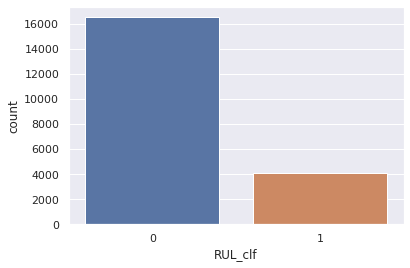

0    16531
1     4100
Name: RUL_clf, dtype: int64


In [ ]:
# The bar graph has been used to determine the class distribution in the data.
sns.countplot(x="RUL_clf",data=df)
plt.show()
print(df["RUL_clf"].value_counts())
df.drop("RUL",axis=1, inplace=True)

In [ ]:
# Performance metrics have been calculated to evaluate the trained model.

def get_clf_model_metrics(model,actual,predicted):
    
    clf_metrics = {
                        "Adjusted Rand Score": adjusted_rand_score(actual, predicted),
                        "Fowlkes Mallows Score":fowlkes_mallows_score(actual, predicted),
                        "Recall Score": recall_score(actual, predicted),
                        "Auc Score": roc_auc_score(actual, predicted),     
                  }
    
    df_clf_metrics = pd.DataFrame.from_dict(clf_metrics, orient='index')
    df_clf_metrics.columns = [model]
    
    return df_clf_metrics

In [ ]:
# In order to train the model, X and y data has beeb prepared according to the outputs obtained from the data exploration section. 
# Afterwards, the dataset has been divided into training and test sets and the models has been trained with the training set.

def fit_model(model, data):
    
    
    X = df.drop(["os1","os2","RUL_clf","sensor_14"],axis=1)
    y = df["RUL_clf"].values
    
    i = 0
    
    for name, clf in model.items():
        print("Fitting model: " + name)
        clf.fit(X)
        
        if name == "K-Means":
            y_pred = clf.predict(X)
            y_pred = (y_pred == 0).astype(int)
            
        elif name == "Auto Encoder":
            y_pred = clf.predict(X)
            
        else:
            y_pred = clf.predict(X)
            y_pred = (y_pred == -1).astype(int)
            
        if i == 0:
            metrics = get_clf_model_metrics(name, y, y_pred)
            print(metrics)
            
        elif i != 0:
            new_metric = get_clf_model_metrics(name, y, y_pred)
            print(new_metric)
            metrics = pd.concat([metrics, new_metric],axis=1)
            
        i= i+1
        print("\n\n")
        
    return metrics

In [ ]:
model = {    
     "One Class SVM": OneClassSVM(),
     "Local Outlier Factor": LocalOutlierFactor(contamination=0.248, novelty=True),
     "K-Means": KMeans(n_clusters = 2, random_state = 42),
     "Isolation Forest": IsolationForest(n_estimators=100, random_state=42, n_jobs=-1, contamination=0.248),
     "Auto Encoder": AutoEncoder(hidden_neurons =[20, 12, 12, 20],contamination = 0.248),
}

In [ ]:
fit_model(model, df)

Fitting model: One Class SVM
                       One Class SVM
Adjusted Rand Score         0.027017
Fowlkes Mallows Score       0.595300
Recall Score                0.707317
Auc Score                   0.629262



Fitting model: Local Outlier Factor
                       Local Outlier Factor
Adjusted Rand Score                0.005806
Fowlkes Mallows Score              0.666761
Recall Score                       0.237317
Auc Score                          0.506143



Fitting model: K-Means
                        K-Means
Adjusted Rand Score    0.252667
Fowlkes Mallows Score  0.695814
Recall Score           0.963171
Auc Score              0.832623



Fitting model: Isolation Forest
                       Isolation Forest
Adjusted Rand Score            0.370995
Fowlkes Mallows Score          0.782479
Recall Score                   0.690000
Auc Score                      0.775797



Fitting model: Auto Encoder
Model: "sequential"
_______________________________________________________

,One Class SVM,Local Outlier Factor,K-Means,Isolation Forest,Auto Encoder
Adjusted Rand Score,0.027017,0.005806,0.252667,0.370995,0.383669
Fowlkes Mallows Score,0.595300,0.666761,0.695814,0.782479,0.786880
Recall Score,0.707317,0.237317,0.963171,0.690000,0.700976
Auc Score,0.629262,0.506143,0.832623,0.775797,0.782646


#### Classification Model Evaluation

5 different algorithms were trained and tested with test sets. As a result, the metrics used for model evaluation were calculated. The metrics are listed in the table from smallest to largest. Accurate prediction of failure moments of turbofans is more important than wrong prediction. The recall score indicates how many of those predicted as positive clusters actually belonged to the positive cluster. The positive set represents our engines that are close to failure within our application. Therefore, recall is the most important criterion in practice. According to the Recall metric, K-means were significantly better than other models in practice, with close values ​​found for autoencoders, single-class SVM, and isolation forests. At this point, the Auc score was checked to observe how successful the two clusters were in separating them from each other. Under these conditions, K-means was the most suitable first model for anomaly detection application, while the second algorithm was determined as autoencoder neural networks.